In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg' #svg
import pylab as plb # this notebook is for plotting
import numpy as np
import scipy as sp
import flylib as flb
import group_data as gd
plb.rcParams['pdf.fonttype'] = 42 #allows text in saved .pdf files to be edited in illustrator
plb.rcParams['image.interpolation'] = 'Nearest'
plb.rcParams['image.cmap'] = 'BrBG'
import warnings
warnings.filterwarnings('ignore')

In [2]:
!ls

01_extract_metadata.ipynb	  detected_saccades_nl_22H05.hdf5
02_apply_saccade_filter.ipynb	  open_loop_rotation_22H05_ptch_roll.hdf5
02_temporal_microstructure.ipynb  Untitled.ipynb


In [3]:
import h5py
mtd_22H05_yaw = h5py.File('../05_basic_open_loop_motion/open_loop_trial_db_22H05.hdf5','r')
mtd_39E01_yaw = h5py.File('../05_basic_open_loop_motion/open_loop_trial_db_39E01.hdf5','r')

In [68]:
#store the selected filter setting in a dictionary. Pickle for later use
import cPickle
with open('../06_saccades/chosen_filter_settings.cpkl','rb') as f:
    chosen_settings = cPickle.load(f)

import os, sys
sac_path = os.path.abspath(os.path.join('..','06_saccades'))
sys.path.append(sac_path)
import findsaccade as fsac

filtdata = fsac.filter_mtrx_nonlinear(mtd_22H05_yaw['normed_signals']['Ph0'],
                           chosen_settings['ksizes'],
                           chosen_settings['mysizes'])

sac_data = ((filtdata>chosen_settings['thresh_vals']*2) + 
            (filtdata<chosen_settings['thresh_vals']*-2)*-1)

In [73]:
saccade_tables_39E01 = h5py.File('../06_saccades/detected_saccades_nl_39E01.hdf5','r')
saccade_tables_22H05 = h5py.File('../06_saccades/detected_saccades_nl_22H05.hdf5','r')

lw_natural_22H05 = gd.signal_plot_info['Ph0']['transform'](
                    (np.array(saccade_tables_22H05['Ph0'])* 
                      np.array(saccade_tables_22H05['lwing_norm'])[:,None]) + \
                        np.array(saccade_tables_22H05['lwing_mean'])[:,None])
    
rw_natural_22H05 = gd.signal_plot_info['Ph1']['transform'](
                    (np.array(saccade_tables_22H05['Ph1'])* 
                      np.array(saccade_tables_22H05['rwing_norm'])[:,None]) + \
                        np.array(saccade_tables_22H05['rwing_mean'])[:,None])
    
lmr_natural_22H05 = gd.signal_plot_info['Ph2']['transform'](
                    (np.array(saccade_tables_22H05['Ph2'])* 
                      np.array(saccade_tables_22H05['lmr_norms'])[:,None]) + \
                        np.array(saccade_tables_22H05['lmr_mean'])[:,None])
    

lw_natural_39E01 = gd.signal_plot_info['Ph0']['transform'](
                    (np.array(saccade_tables_39E01['Ph0'])* 
                      np.array(saccade_tables_39E01['lwing_norm'])[:,None]) + \
                        np.array(saccade_tables_39E01['lwing_mean'])[:,None])
    
rw_natural_39E01 = gd.signal_plot_info['Ph1']['transform'](
                    (np.array(saccade_tables_39E01['Ph1'])* 
                      np.array(saccade_tables_39E01['rwing_norm'])[:,None]) + \
                        np.array(saccade_tables_39E01['rwing_mean'])[:,None])
    
lmr_natural_39E01 = gd.signal_plot_info['Ph2']['transform'](
                    (np.array(saccade_tables_39E01['Ph2'])* 
                      np.array(saccade_tables_39E01['lmr_norms'])[:,None]) + \
                        np.array(saccade_tables_39E01['lmr_mean'])[:,None])

sort_sig_22H05 = np.mean(rw_natural_22H05[:,49:51],axis = 1) - np.mean(rw_natural_22H05[:,:30],axis = 1)
sort_sig_39E01 = np.mean(rw_natural_39E01[:,49:51],axis = 1) - np.mean(rw_natural_39E01[:,:30],axis = 1)

sort_idx_22H05 = np.argsort(sort_sig_22H05,axis = 0)
sort_idx_39E01 = np.argsort(sort_sig_39E01,axis = 0)

In [92]:
#create dict of sorted trials in memory
sorted_saccades_22H05 = dict()
[sorted_saccades_22H05.update({sig:np.array(saccade_tables_22H05[sig])[sort_idx_22H05]}) for 
                                                sig in saccade_tables_22H05.keys()];
sorted_saccades_39E01 = dict()
[sorted_saccades_39E01.update({sig:np.array(saccade_tables_39E01[sig])[sort_idx_39E01]}) for 
                                                sig in saccade_tables_39E01.keys()];



In [279]:
percentile_ranges_22H05 = np.linspace(0,np.shape(sorted_saccades_22H05['Ph2'])[0],100).astype(int)[::-1]
decile_brackets_22H05 = zip(percentile_ranges_22H05[9:110:10],percentile_ranges_22H05[0:100:10])

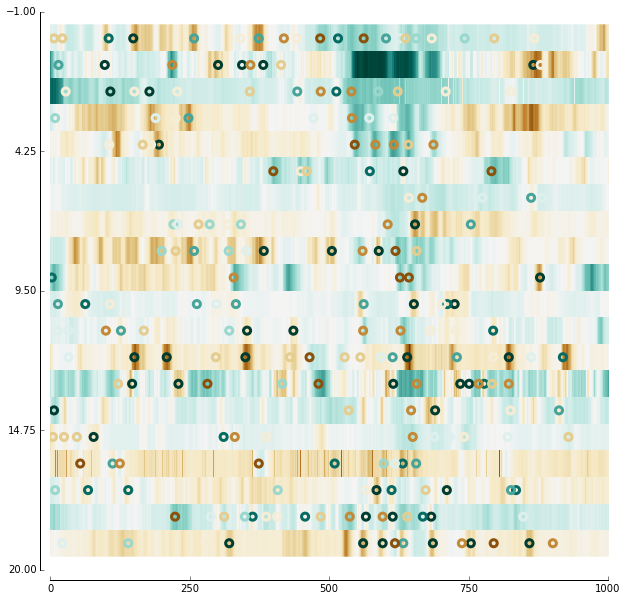

In [362]:
import plotfuncs as plf
plb.figure(figsize = (10,10))
%config InlineBackend.figure_format = 'png'
plb.imshow(np.array(mtd_22H05_yaw['normed_signals']['b3'])[selection_rows,:][down_samp_idx,:],aspect = 'auto')
sub_samples = 20
for top_start,top_stop in decile_brackets_22H05:
    top_mask = (np.arange(len(sorted_saccades_22H05['peak']))<top_stop) & \
                (np.arange(len(sorted_saccades_22H05['peak']))>top_start)
    selection_rows = np.squeeze(np.argwhere(trial_names == 'yaw_left'))
    down_samp_idx = np.linspace(2,len(selection_rows)-2,sub_samples).astype(int)
    selection_mask = np.any([sorted_saccades_22H05['row'] == x for x in selection_rows],axis = 0)
    down_samp_mask = np.zeros_like(selection_mask)
    raster_rows = np.empty_like(selection_mask).astype(int)
    raster_rows[:] = np.nan
    rowcount = 0
    for i,rownum in enumerate(selection_rows):
        if i in down_samp_idx:
            down_samp_mask += sorted_saccades_22H05['row'] == rownum
            raster_rows[sorted_saccades_22H05['row'] == rownum] = rowcount
            rowcount += 1
            #print rowcount
    c = plb.cm.BrBG(float(top_stop)/decile_brackets_22H05[1][-1])
    plb.scatter(sorted_saccades_22H05['peak'][top_mask & selection_mask & down_samp_mask],
                raster_rows[top_mask & selection_mask & down_samp_mask]
                ,alpha = 1,rasterized = True,color = c,s = 50,lw = 3,facecolor = 'None')
plb.gca().set_xbound(0,1000)
plb.gca().set_ybound(-1,20)
plf.pull_ax_spines()

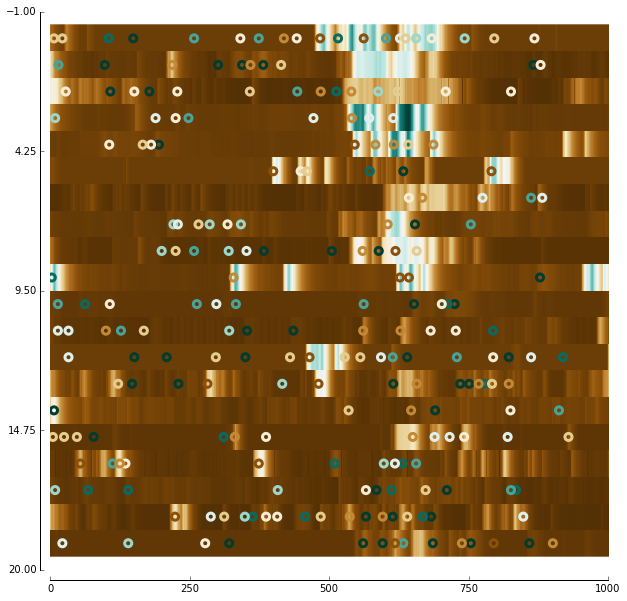

In [363]:
import plotfuncs as plf
plb.figure(figsize = (10,10))
%config InlineBackend.figure_format = 'png'
plb.imshow(np.array(mtd_22H05_yaw['normed_signals']['i1'])[selection_rows,:][down_samp_idx,:],aspect = 'auto')
sub_samples = 20
for top_start,top_stop in decile_brackets_22H05:
    top_mask = (np.arange(len(sorted_saccades_22H05['peak']))<top_stop) & \
                (np.arange(len(sorted_saccades_22H05['peak']))>top_start)
    selection_rows = np.squeeze(np.argwhere(trial_names == 'yaw_left'))
    down_samp_idx = np.linspace(2,len(selection_rows)-2,sub_samples).astype(int)
    selection_mask = np.any([sorted_saccades_22H05['row'] == x for x in selection_rows],axis = 0)
    down_samp_mask = np.zeros_like(selection_mask)
    raster_rows = np.empty_like(selection_mask).astype(int)
    raster_rows[:] = np.nan
    rowcount = 0
    for i,rownum in enumerate(selection_rows):
        if i in down_samp_idx:
            down_samp_mask += sorted_saccades_22H05['row'] == rownum
            raster_rows[sorted_saccades_22H05['row'] == rownum] = rowcount
            rowcount += 1
            #print rowcount
    c = plb.cm.BrBG(float(top_stop)/decile_brackets_22H05[1][-1])
    plb.scatter(sorted_saccades_22H05['peak'][top_mask & selection_mask & down_samp_mask],
                raster_rows[top_mask & selection_mask & down_samp_mask]
                ,alpha = 1,rasterized = True,color = c,s = 50,lw = 3,facecolor = 'None')
plb.gca().set_xbound(0,1000)
plb.gca().set_ybound(-1,20)
plf.pull_ax_spines()

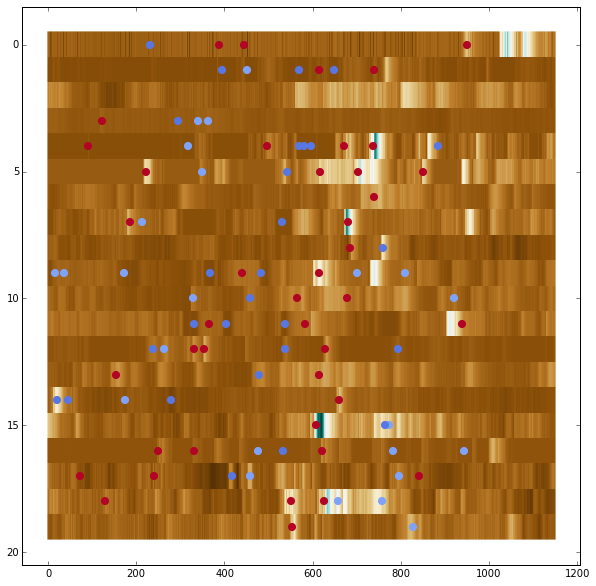

In [427]:
plb.figure(figsize = (10,10))
%config InlineBackend.figure_format = 'png'
plb.imshow(np.array(mtd_22H05_yaw['normed_signals']['b2'])[selection_rows,:][down_samp_idx,:],aspect = 'auto')
sub_samples = 20
histdata = dict()

for top_start,top_stop in [decile_brackets_22H05[x] for x in [0,1,-2,-1]]:
    top_mask = (np.arange(len(sorted_saccades_22H05['peak']))<top_stop) & \
                (np.arange(len(sorted_saccades_22H05['peak']))>top_start)
    selection_rows = np.squeeze(np.argwhere(trial_names == 'yaw_right'))
    down_samp_idx = np.linspace(2,len(selection_rows)-2,sub_samples).astype(int)
    selection_mask = np.any([sorted_saccades_22H05['row'] == x for x in selection_rows],axis = 0)
    down_samp_mask = np.zeros_like(selection_mask)
    raster_rows = np.empty_like(selection_mask).astype(int)
    raster_rows[:] = np.nan
    rowcount = 0
    for i,rownum in enumerate(selection_rows):
        if i in down_samp_idx:
            down_samp_mask += sorted_saccades_22H05['row'] == rownum
            raster_rows[sorted_saccades_22H05['row'] == rownum] = rowcount
            rowcount += 1
    c = plb.cm.coolwarm(float(top_stop)/decile_brackets_22H05[1][-1])
    plb.scatter(sorted_saccades_22H05['peak'][top_mask & selection_mask & down_samp_mask],
                raster_rows[top_mask & selection_mask & down_samp_mask]
                ,alpha = 1,rasterized = True,color = c,s = 50)
    xi = gd.get_xio('yaw_left')
    bins = np.arange(xi[0],xi[-1],1)
    vals,bins = np.histogram(xi[sorted_saccades_22H05['peak'][top_mask & selection_mask]],bins = bins)
    histdata[decile] = (vals,bins)
    decile += 1


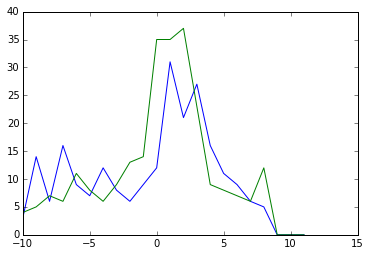

In [422]:
plb.plot(histdata[0][1][:-1],histdata[0][0])
plb.plot(histdata[1][1][:-1],histdata[1][0])

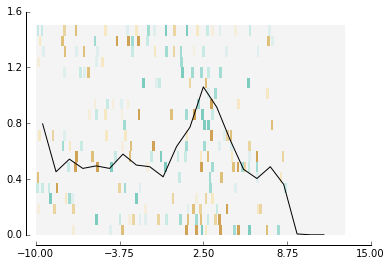

In [589]:
sub_samples = 20

sac_raster = np.zeros((sub_samples,len(xi)))
decile = 0
histdata = dict()
for top_start,top_stop in decile_brackets_22H05:
    top_mask = (np.arange(len(sorted_saccades_22H05['peak']))<top_stop) & \
                (np.arange(len(sorted_saccades_22H05['peak']))>top_start)
    selection_rows = np.squeeze(np.argwhere(trial_names == 'yaw_left'))
    down_samp_idx = np.linspace(2,len(selection_rows)-2,sub_samples).astype(int)
    selection_mask = np.any([sorted_saccades_22H05['row'] == x for x in selection_rows],axis = 0)
    down_samp_mask = np.zeros_like(selection_mask)
    raster_rows = np.empty_like(selection_mask).astype(int)
    raster_rows[:] = np.nan
    rowcount = 0
    for i,rownum in enumerate(selection_rows):
        if i in down_samp_idx:
            down_samp_mask += sorted_saccades_22H05['row'] == rownum
            raster_rows[sorted_saccades_22H05['row'] == rownum] = rowcount
            rowcount += 1
    clvl = decile/10.0
    
    for rw,cl in zip(raster_rows[top_mask & selection_mask & down_samp_mask],
                     sorted_saccades_22H05['peak'][top_mask & selection_mask & down_samp_mask]):
        sac_raster[rw,cl-5:cl+5] = clvl-0.5
    bins = np.arange(xi[0],xi[-1],1)
    vals,bins = np.histogram(xi[sorted_saccades_22H05['peak'][top_mask & selection_mask]],bins = bins)
    histdata[decile] = (vals,bins)
    decile +=1

leftward_hist = np.sum([histdata[d][0] for d in range(5)],axis =0)
rightward_hist = np.sum([histdata[d][0] for d in range(5,10)],axis = 0)
leftward_top_hist = histdata[0][0]
rightward_top_hist = histdata[9][0]
total_hist = np.sum([histdata[d][0] for d in range(10)],axis = 0)

edges = histdata[0][1]
lower_bins = np.resize(edges,len(edges)-1)
tmid = lower_bins + 0.5*np.diff(edges)

plb.imshow(sac_raster,vmin = -1,vmax =1,extent = (xi[0],xi[-1],0,1.5),aspect = 'auto')
plb.plot(tmid,total_hist/np.float(np.shape(selection_rows)[0]),color = 'k')
#plf.pull_ax_spines()
    #c = plb.cm.coolwarm(clvl)
    #plb.scatter(sorted_saccades_22H05['peak'][top_mask & selection_mask & down_samp_mask],
    #            raster_rows[top_mask & selection_mask & down_samp_mask]
    #            ,alpha = 1,rasterized = True,color = c,s = 50)

In [595]:
xi[-1] - (xi[1]-xi[0])*50

11.999129677980857

In [593]:
xi[-1]

13.0

In [560]:
upper_hist

948

In [465]:
import plotfuncs as pf
reload(gd)
example_trial = 13
trial = 'yaw_left'

row_keys = ['yaw_left','yaw_right','ascending']
col_keys= ['Ph2','Ph1','Sac','b2','b3','i1','i2']

z_rng = {'Ph2':6,'Ph1':6,'Sac':1.5,'b2':6,'i1':6,'i2':6,'b3':6}
pltrng = (-3,12)

rows = len(row_keys)
cols = len(col_keys)+1

row_epochs = None
col_epochs  = (0,3)
row_labels_right = [None for j in range(rows)]

ybounds = [(0,200) for j in range(rows)] 
xbounds = [(-3,12) for j in range(cols)]  

#Columns are muscles 
col_labels_bottom = [None for i in range(cols)] 
col_labels_bottom[-1] = 'time (s)'

col_labels_top = [gd.signal_plot_info[sig]['ax_label'] for sig in col_keys]
col_labels_top = ['trial#%s'%(example_trial)] + col_labels_top

#rows are trial types
row_labels_left = [gd.trial_to_label[trial] for trial in row_keys]

show_spines_left = [False for j in range(rows)]
show_spines_left[0] = True
show_spines_right = [False for j in range(rows)]
show_spines_right[0] = True

show_spines_top = False
show_spines_bottom = [False for j in range(cols)]
show_spines_bottom[-1] = True

ytick_numbers = [3 for j in range(rows)]
xtick_numbers = [6 for i in range(cols)]
col_epochs_kwargs = {'alpha':0.5,'color':'b','clip_on':False,'lw':1,'fill':False}
figsize = (10,5)
sub_samples = 20

In [466]:
trial_names = np.array(mtd_22H05_yaw['selected_signals']['trial_names'])
def get_selection_mtrx(signal,trial):
    selection = trial_names == trial
    if signal == 'Sac':
        return sac_data[selection,:]
    else:
        return np.array(mtd_22H05_yaw['normed_signals'][signal][selection,:])

import copy

def plot_selection_mtrx(col,row):
    import plotfuncs as pf

    if col > 0:
        signal = col_keys[col-1]
        trial = row_keys[row]

        data_selection = get_selection_mtrx(signal,trial)#np.array(trial_db[signal])[selection,:]

        xi = gd.get_xio('yaw_left')
        down_samp_idx = np.linspace(2,data_selection.shape[0]-2,sub_samples).astype(int)
        plb.imshow(data_selection[down_samp_idx,:],aspect = 'auto',cmap = plb.cm.BrBG,extent = (xi[0],xi[-1],0,200),
              vmin = -z_rng[signal],vmax = z_rng[signal],interpolation = 'nearest')
        sig = np.mean(data_selection,axis = 0)
        pltidx = (xi>pltrng[0]) & (xi<pltrng[1])
        plb.plot(xi[pltidx],sig[pltidx]*(400/8.0) + 100,clip_on = False,color = 'k')
        
    if col == 0:
        signal = col_keys[col]
        trial = row_keys[row]

        data_selection = copy.copy(get_selection_mtrx(signal,trial))
        ### to re-introduce natural units.        
        if signal in ['Ph0','Ph1']:
            selection = trial_names == trial
            mns = mtd_22H05_yaw['signal_means'][signal][selection]
            stds =  mtd_22H05_yaw['signal_norms'][signal][selection]
            data_selection *= stds[:,None]
            data_selection += mns[:,None]
        
        xi = gd.get_xio('yaw_left')
        down_samp_idx = np.linspace(2,data_selection.shape[0]-2,sub_samples).astype(int)
        sig = data_selection[down_samp_idx,:][example_trial]
        pltidx = (xi>pltrng[0]) & (xi<pltrng[1])
        plb.plot(xi[pltidx],sig[pltidx]*(100/8.0) + 100,clip_on = False,color = 'k')

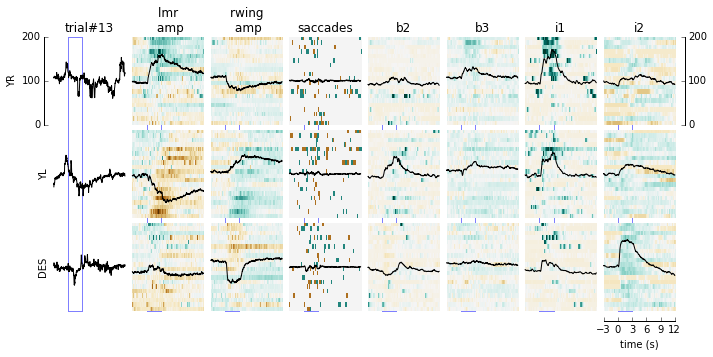

In [467]:
#############################
## Plot raster plots, all rasters sorted by behavioral responses
#############################
ax_grid,row_ep_pans,col_ep_pans = pf.plot_data_matrix(plot_panel_function = plot_selection_mtrx,
                               rows = rows,cols = cols,
                               row_epochs = row_epochs,
                               col_epochs = col_epochs,
                               ybounds = ybounds,
                               xbounds = xbounds,
                               figsize = figsize,
                               col_labels_top = col_labels_top,
                               col_labels_bottom = col_labels_bottom,
                               show_spines_left = show_spines_left,
                               show_spines_right = show_spines_right,
                               show_spines_bottom = show_spines_bottom,
                               show_spines_top = show_spines_top,
                               row_labels_left = row_labels_left,
                               row_labels_right = row_labels_right,
                               ytick_numbers = ytick_numbers,
                               xtick_numbers = xtick_numbers,
                               col_epochs_kwargs = col_epochs_kwargs)

#[ax.set_zorder(11) for ax in col_ep_pans];

# add the color key
#rect = l,b,w,h
#rect = 0.93,0.73,0.025,0.1
#plb.gcf().add_axes(rect)
#plb.gca().yaxis.set_label_position("right")
#plb.imshow(np.array([np.linspace(8,-8)]).T,cmap = plb.cm.BrBG,extent = (0,1,-4,4))
#plb.yticks(np.linspace(-4,4,3))
#plb.gca().set_yticklabels([u'-%s $\u03C3$'%(z_rng['Ph1']),'0',u'%s $\u03C3$'%(z_rng['Ph1'])])
#pf.kill_spines()
#plb.gca().spines['right'].set_visible(True)
#plb.gca().spines['right'].set_position(('outward',10))

#plb.tick_params(axis='y', which='both', labelleft='off', labelright='on')
#[y.set_visible(False) for y in plb.gca().get_yticklines()[::2]]

#lbax = ax_grid[0][-1][1]
#new_labels = [str(x) for x in np.linspace(-2,2,3)]
#new_labels[0] = u'%s $\u03C3$'%(new_labels[0])
#new_labels[-1] = u'%s $\u03C3$'%(new_labels[-1])
#lbax.set_yticklabels(new_labels,y=2)

#lbax = ax_grid[0][0]
#new_labels = [str(x) for x in np.linspace(-4,4,3)]
#new_labels[0] = u'%s $\u03C3$'%(new_labels[0])
#new_labels[-1] = u'%s $\u03C3$'%(new_labels[-1])
#lbax.set_yticklabels(new_labels)

#arrow_vpos = 200-(200/sub_samples)*example_trial - 4

#import matplotlib
#for row in ax_grid:
#    plb.sca(row[1])
#    arr = matplotlib.patches.FancyArrowPatch(posA=(-4,arrow_vpos), posB=(-3,arrow_vpos), 
#                              arrowstyle='->',  
#                              patchA=None, patchB=None, shrinkA=0.3, shrinkB=0.3,
#                              mutation_scale=10.0, mutation_aspect=None, dpi_cor=1.0,clip_on = False,color = 'r',
#                              lw=2)
#    plb.gca().add_patch(arr)

#plb.draw()
#plb.savefig('trial_rasters_with_examples_sorted_by_behavior.pdf')

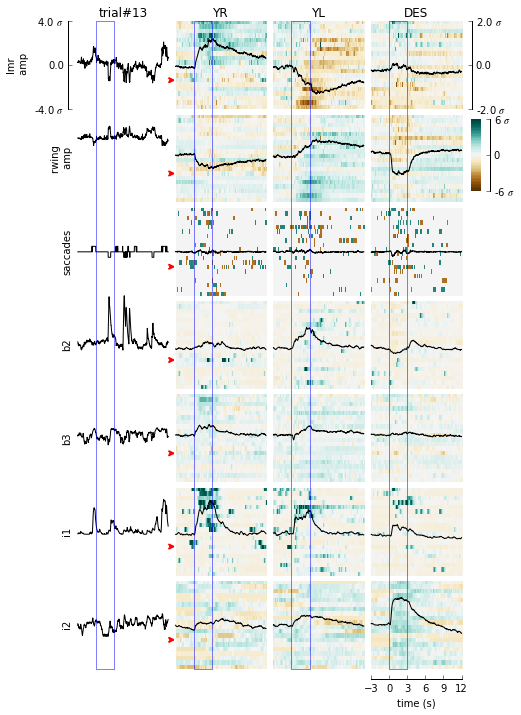

In [366]:
#############################
## Plot raster plots, all rasters sorted by behavioral responses
#############################
ax_grid,row_ep_pans,col_ep_pans = pf.plot_data_matrix(plot_panel_function = plot_selection_mtrx,
                               rows = rows,cols = cols,
                               row_epochs = row_epochs,
                               col_epochs = col_epochs,
                               ybounds = ybounds,
                               xbounds = xbounds,
                               figsize = figsize,
                               col_labels_top = col_labels_top,
                               col_labels_bottom = col_labels_bottom,
                               show_spines_left = show_spines_left,
                               show_spines_right = show_spines_right,
                               show_spines_bottom = show_spines_bottom,
                               show_spines_top = show_spines_top,
                               row_labels_left = row_labels_left,
                               row_labels_right = row_labels_right,
                               ytick_numbers = ytick_numbers,
                               xtick_numbers = xtick_numbers,
                               col_epochs_kwargs = col_epochs_kwargs)

[ax.set_zorder(11) for ax in col_ep_pans];

# add the color key
#rect = l,b,w,h
rect = 0.93,0.73,0.025,0.1
plb.gcf().add_axes(rect)
plb.gca().yaxis.set_label_position("right")
plb.imshow(np.array([np.linspace(8,-8)]).T,cmap = plb.cm.BrBG,extent = (0,1,-4,4))
plb.yticks(np.linspace(-4,4,3))
plb.gca().set_yticklabels([u'-%s $\u03C3$'%(z_rng['Ph1']),'0',u'%s $\u03C3$'%(z_rng['Ph1'])])
pf.kill_spines()
plb.gca().spines['right'].set_visible(True)
plb.gca().spines['right'].set_position(('outward',10))

plb.tick_params(axis='y', which='both', labelleft='off', labelright='on')
[y.set_visible(False) for y in plb.gca().get_yticklines()[::2]]

lbax = ax_grid[0][-1][1]
new_labels = [str(x) for x in np.linspace(-2,2,3)]
new_labels[0] = u'%s $\u03C3$'%(new_labels[0])
new_labels[-1] = u'%s $\u03C3$'%(new_labels[-1])
lbax.set_yticklabels(new_labels,y=2)

lbax = ax_grid[0][0]
new_labels = [str(x) for x in np.linspace(-4,4,3)]
new_labels[0] = u'%s $\u03C3$'%(new_labels[0])
new_labels[-1] = u'%s $\u03C3$'%(new_labels[-1])
lbax.set_yticklabels(new_labels)

arrow_vpos = 200-(200/sub_samples)*example_trial - 4

import matplotlib
for row in ax_grid:
    plb.sca(row[1])
    arr = matplotlib.patches.FancyArrowPatch(posA=(-4,arrow_vpos), posB=(-3,arrow_vpos), 
                              arrowstyle='->',  
                              patchA=None, patchB=None, shrinkA=0.3, shrinkB=0.3,
                              mutation_scale=10.0, mutation_aspect=None, dpi_cor=1.0,clip_on = False,color = 'r',
                              lw=2)
    plb.gca().add_patch(arr)

plb.draw()
plb.savefig('trial_rasters_with_examples_sorted_by_behavior.pdf')

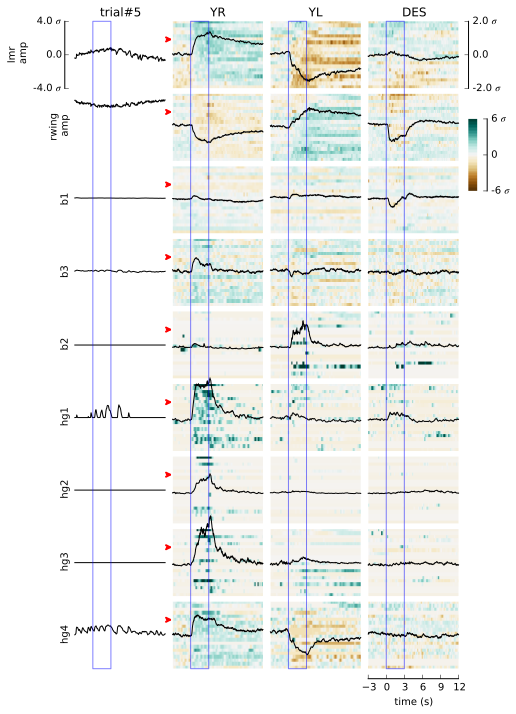

In [10]:
import plotfuncs as pf

example_trial = 5
trial = 'yaw_left'
col_keys = ['yaw_left','yaw_right','ascending']
row_keys = ['Ph2','Ph1','b1','b3','b2','hg1','hg2','hg3','hg4']

z_rng = 6
pltrng = (-3,12)

rows = len(row_keys)
cols = len(col_keys)+1

row_epochs = None
col_epochs  = (0,3)
row_labels_right = [None for j in range(rows)]

ybounds = [(0,200) for j in range(rows)] 
xbounds = [(-3,12) for j in range(cols)]  

col_labels_bottom = [None for i in range(cols)] 
col_labels_bottom[-1] = 'time (s)'
row_labels_left = [gd.signal_plot_info[sig]['ax_label'] for sig in row_keys]

col_labels_top = [gd.trial_to_label[trial] for trial in col_keys]
col_labels_top = ['trial#%s'%(example_trial)] + col_labels_top

show_spines_left = [False for j in range(rows)]
show_spines_left[0] = True
show_spines_right = [False for j in range(rows)]
show_spines_right[0] = True

show_spines_top = False
show_spines_bottom = [False for j in range(cols)]
show_spines_bottom[-1] = True

ytick_numbers = [3 for j in range(rows)]
xtick_numbers = [6 for i in range(cols)]
col_epochs_kwargs = {'alpha':0.5,'color':'b','clip_on':False,'lw':1,'fill':False}
figsize = (6.85039,10)
sub_samples = 20

trial_names = np.array(mtd_39E01['selected_signals']['trial_names'])
def get_selection_mtrx(signal,trial):
    selection = trial_names == trial
    return np.array(mtd_39E01['normed_signals'][signal][selection,:])

def plot_selection_mtrx(col,row):
    import plotfuncs as pf
    if col > 0:
        signal = row_keys[row]
        trial = col_keys[col-1]
        data_selection = get_selection_mtrx(signal,trial)#np.array(trial_db[signal])[selection,:]
        xi = gd.get_xio('yaw_left')
        down_samp_idx = np.linspace(2,data_selection.shape[0]-2,sub_samples).astype(int)
        plb.imshow(data_selection[down_samp_idx,:],aspect = 'auto',cmap = plb.cm.BrBG,extent = (xi[0],xi[-1],0,200),
              vmin = -z_rng,vmax = z_rng,interpolation = 'nearest')
        sig = np.mean(data_selection,axis = 0)
        pltidx = (xi>pltrng[0]) & (xi<pltrng[1])
        plb.plot(xi[pltidx],sig[pltidx]*(400/8.0) + 100,clip_on = False,color = 'k')
        
    if col == 0:
        signal = row_keys[row]
        trial = col_keys[col]
        data_selection = get_selection_mtrx(signal,trial)
        xi = gd.get_xio('yaw_left')
        ### to re-introduce natural units.        
        selection = trial_names == trial
        mns = mtd_39E01['signal_means'][signal][selection]
        stds =  mtd_39E01['signal_norms'][signal][selection]
        data_selection *= stds[:,None]
        data_selection += mns[:,None]
        
        down_samp_idx = np.linspace(2,data_selection.shape[0]-2,sub_samples).astype(int)
        sig = data_selection[down_samp_idx,:][example_trial]
        pltidx = (xi>pltrng[0]) & (xi<pltrng[1])
        plb.plot(xi[pltidx],sig[pltidx]*(100/8.0) + 100,clip_on = False,color = 'k')

#############################
## Plot raster plots, all rasters sorted by behavioral responses
#############################
ax_grid,row_ep_pans,col_ep_pans = pf.plot_data_matrix(plot_panel_function = plot_selection_mtrx,
                               rows = rows,cols = cols,
                               row_epochs = row_epochs,
                               col_epochs = col_epochs,
                               ybounds = ybounds,
                               xbounds = xbounds,
                               figsize = figsize,
                               col_labels_top = col_labels_top,
                               col_labels_bottom = col_labels_bottom,
                               show_spines_left = show_spines_left,
                               show_spines_right = show_spines_right,
                               show_spines_bottom = show_spines_bottom,
                               show_spines_top = show_spines_top,
                               row_labels_left = row_labels_left,
                               row_labels_right = row_labels_right,
                               ytick_numbers = ytick_numbers,
                               xtick_numbers = xtick_numbers,
                               col_epochs_kwargs = col_epochs_kwargs)

[ax.set_zorder(11) for ax in col_ep_pans];

# add the color key
#rect = l,b,w,h
rect = 0.93,0.73,0.025,0.1
plb.gcf().add_axes(rect)
plb.gca().yaxis.set_label_position("right")
plb.imshow(np.array([np.linspace(8,-8)]).T,cmap = plb.cm.BrBG,extent = (0,1,-4,4))
plb.yticks(np.linspace(-4,4,3))
plb.gca().set_yticklabels([u'-%s $\u03C3$'%(z_rng),'0',u'%s $\u03C3$'%(z_rng)])
pf.kill_spines()
plb.gca().spines['right'].set_visible(True)
plb.gca().spines['right'].set_position(('outward',10))

plb.tick_params(axis='y', which='both', labelleft='off', labelright='on')
[y.set_visible(False) for y in plb.gca().get_yticklines()[::2]]

lbax = ax_grid[0][-1][1]
new_labels = [str(x) for x in np.linspace(-2,2,3)]
new_labels[0] = u'%s $\u03C3$'%(new_labels[0])
new_labels[-1] = u'%s $\u03C3$'%(new_labels[-1])
lbax.set_yticklabels(new_labels,y=2)

lbax = ax_grid[0][0]
new_labels = [str(x) for x in np.linspace(-4,4,3)]
new_labels[0] = u'%s $\u03C3$'%(new_labels[0])
new_labels[-1] = u'%s $\u03C3$'%(new_labels[-1])
lbax.set_yticklabels(new_labels)

arrow_vpos = 200-(200/sub_samples)*example_trial - 4

import matplotlib
for row in ax_grid:
    plb.sca(row[1])
    arr = matplotlib.patches.FancyArrowPatch(posA=(-4,arrow_vpos), posB=(-3,arrow_vpos), 
                              arrowstyle='->',  
                              patchA=None, patchB=None, shrinkA=0.3, shrinkB=0.3,
                              mutation_scale=10.0, mutation_aspect=None, dpi_cor=1.0,clip_on = False,color = 'r',
                              lw=2)
    plb.gca().add_patch(arr)

plb.draw()
plb.savefig('trial_rasters_with_examples_sorted_by_behavior_39E01.pdf')